In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [74]:
from src.activation_functions import *
from src.loss_functions import *
from src.random_search import *
from src.batch_normalization import *
from src.layer import *
from src.early_stopping import *
from src.utils import *
from src.optimizers import *
import itertools
import pandas as pd
import numpy as np
import sys
import os


In [75]:
df_path = "../ML_project/data/cup/ML-CUP24-TR.csv"
df_path2 = "../ML_project/data/cup/ML-CUP24-TS.csv"

# Preview the dataset
df = pd.read_csv(df_path, skiprows=7, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0.946373,0.307995,0.820058,-0.309386,0.950936,-0.000913,-0.093048,-0.029318,0.995230,-1.175176,2.295016,0.223732,-0.011599,-0.503652,-5.564158
1,2,-0.074075,-0.992654,-1.162582,0.997240,-0.074209,-0.002159,-0.004956,-0.095561,0.995411,0.675930,3.147029,-0.297508,-0.361982,-0.186246,3.445744
2,3,0.841384,0.531605,0.810176,-0.534053,0.845451,-0.001057,-0.082832,-0.051079,0.995254,-1.069958,2.415989,0.234664,0.170027,-0.344143,-3.675575
3,4,0.737117,-0.668400,-1.065601,0.671734,0.740793,0.000008,0.073704,-0.066844,0.995038,11.038418,1.003455,-0.100332,-1.032355,-1.184874,15.554511
4,5,-0.987858,-0.119426,-1.072857,0.120013,-0.992772,0.000064,-0.098661,-0.011863,0.995050,14.834930,1.127759,-0.112600,-0.134817,2.047468,20.522760


In [76]:
df.columns = ["ID"] + [f'input_{i}' for i in range(12)] + ['target_x', 'target_y', 'target_z']
df = df.drop("ID", axis=1)

In [77]:
X_train, X_val, y_train, y_val, X_scaler, y_scaler = preprocess_data(
    df, 
    target=["target_x", "target_y", "target_z"],
    normalize_type="z-score",
    val_ratio=0.2,
    regression=True
)

           0         1          2
0  -0.421997  0.236717  -7.342594
1  -0.283333  0.050838   3.428940
2   0.137419  0.030498  -2.907336
3   1.758643 -0.886580  16.933458
4  -1.091619  0.158737   2.392301
5  -0.030139 -0.041892  -0.703612
6  -0.537285  0.111040   2.657905
7  -0.296103  0.080915   2.885263
8  -1.578751 -0.185479  14.876680
9   1.155768 -0.025354  12.329478
10  0.237865  0.755455   7.693303
11  0.880421  0.209778  -8.828166
12  0.687578  0.985988  14.896379
13  0.762072  0.217130  -9.108539
14 -2.156456 -0.696712  20.812513
15 -0.494655  0.115973  -5.513408
16 -1.620315 -0.362419  17.202943
17  0.149752  0.676320   8.854500
18 -0.794149 -1.553299  17.377104
19 -0.049514  0.745878   8.182392
20  2.333131 -0.558883  24.923707
21  1.227097  0.381899  14.242438
22 -0.740300  0.539295   8.972121
23 -1.312315 -1.067413  16.626081
24  0.588437  0.455289  -9.114358
25 -1.013359 -0.028985   8.870993
26  1.082475 -1.512010  18.644240
27  0.109942  0.027452  -2.324193
28  0.602006  

In [78]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((200, 12), (200, 3), (50, 12), (50, 3))

In [79]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [99]:
param_distributions = {
    'hidden_size': [12],
    'n_h_layers': [5],
    'hidden_activation': [Activation_Tanh, Activation_ReLU],
    'batch_norm': [True],
    'learning_rate': np.logspace(-3, -1, num=5).tolist(),
    'l1':  np.logspace(-7, -5, num=5).tolist(),
    'l2': np.logspace(-7, -2, num=5).tolist(),
    'dropout_rate': np.logspace(-4, -2, num=5).tolist(),
    'batch_size': [32, 64],
    'n_epochs': [300],
    'weight_decay': np.logspace(-4, -1, num=5).tolist(),
    'patience': [90],
    'CC': [False],
    'weights_init': ['gaussian', 'xavier', 'gaussian_scaled'],
}

print(f"Number of possible combinations: {count_permutations(param_distributions)}")

Number of possible combinations: 37500


In [100]:
best_hyperparams, best_performance = random_search(X_train=X_train,
                                                   y_train=y_train,
                                                   param_distributions=param_distributions,
                                                   n_iters=5, regression=True, csv_path="cup_top5res.csv")  # adjust n_iters as needed

print(best_hyperparams)

✅ Fold 1/5 | Validation Accuracy: 0.3308
✅ Fold 2/5 | Validation Accuracy: 0.4551
✅ Fold 3/5 | Validation Accuracy: 0.2909
✅ Fold 4/5 | Validation Accuracy: 0.3731
✅ Fold 5/5 | Validation Accuracy: 0.4508

📊 Manual K-Fold | Mean Validation Accuracy over 5 folds: 0.3801
✅ Fold 1/5 | Validation Accuracy: 0.3415
✅ Fold 2/5 | Validation Accuracy: 0.4567
✅ Fold 3/5 | Validation Accuracy: 0.3002
✅ Fold 4/5 | Validation Accuracy: 0.3747
✅ Fold 5/5 | Validation Accuracy: 0.4550

📊 Manual K-Fold | Mean Validation Accuracy over 5 folds: 0.3856
✅ Fold 1/5 | Validation Accuracy: 0.3234
✅ Fold 2/5 | Validation Accuracy: 0.4442
✅ Fold 3/5 | Validation Accuracy: 0.2963
✅ Fold 4/5 | Validation Accuracy: 0.3329
✅ Fold 5/5 | Validation Accuracy: 0.4398

📊 Manual K-Fold | Mean Validation Accuracy over 5 folds: 0.3673
✅ Fold 1/5 | Validation Accuracy: 0.3276
✅ Fold 2/5 | Validation Accuracy: 0.4287
✅ Fold 3/5 | Validation Accuracy: 0.2846
✅ Fold 4/5 | Validation Accuracy: 0.3583
✅ Fold 5/5 | Validation Ac

In [101]:
print(best_hyperparams)

{'hidden_size': 12, 'n_h_layers': 5, 'hidden_activation': <class 'src.activation_functions.Activation_Tanh'>, 'batch_norm': True, 'learning_rate': 0.1, 'l1': 1e-07, 'l2': 1.778279410038923e-06, 'dropout_rate': 0.00031622776601683794, 'batch_size': 64, 'n_epochs': 300, 'weight_decay': 0.0005623413251903491, 'patience': 90, 'CC': False, 'weights_init': 'xavier', 'val_accuracy': np.float64(0.385607764593232)}


Final Validation R² Score: 0.3645; Loss 0.6483


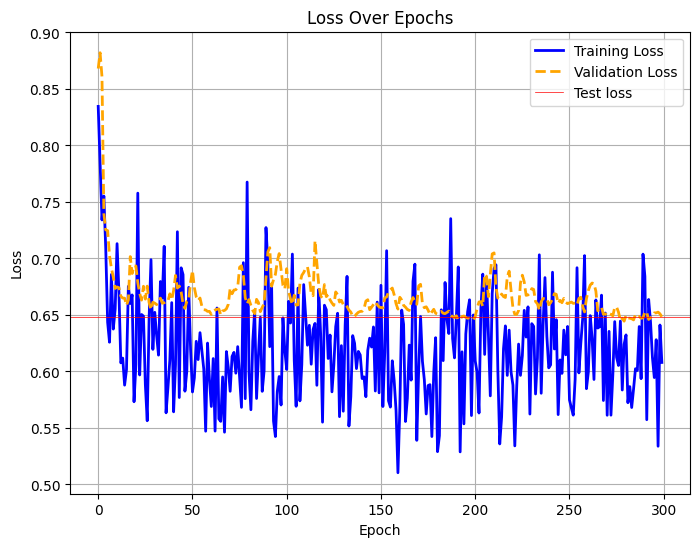

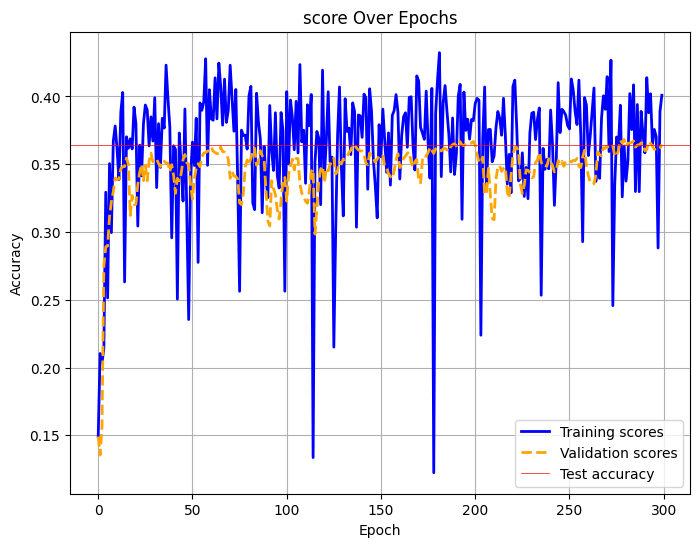

In [102]:
if best_hyperparams['CC']:
    model = CascadeCorrelation(input_size = 12, output_size=3, activation=Activation_Leaky_ReLU, output_activation = Activation_Sigmoid)
else:
    model = NN(
        l1=best_hyperparams['l1'],
        l2=best_hyperparams['l2'],
        input_size=12,
        hidden_size=best_hyperparams['hidden_size'],
        output_size=3,
        hidden_activation=best_hyperparams['hidden_activation'],
        dropout_rate=best_hyperparams['dropout_rate'],
        use_batch_norm=best_hyperparams['batch_norm'],
        n_h_layers=best_hyperparams['n_h_layers']
    )

train = Train(best_hyperparams, model, regression=True)
train.train_and_evaluate(X_train, y_train, X_val, y_val)
train.test(X_val, y_val)
print(f"Final Validation R² Score: {train.test_score:.4f}; Loss {train.test_loss:.4f}")
train.plot(score=True)